<a href="https://colab.research.google.com/github/yinpu/deep_learning_study/blob/master/MFFRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 数据预处理

In [ ]:
#数据预处理函数
import numpy as np
import os
import  tensorflow as tf

RATING_FILE_NAME={
    'movie': 'ratings.dat',
    'book':'BX-Book-Ratings.csv',
    'music':'user_artists.dat'
}
SEP={
    'movie':'::',
    'book':';',
    'music':'\t'
}
THRESHOLD={
    'movie':4,
    'book':0,
    'music':0
}
DATASETS={'movie','book','music'}

def read_item_index2entity_id_file():
    file = './data/'+DATASET+'/item_index2entity_id.txt'
    i=0
    for line in open(file,encoding='utf-8').readlines():
        item_index=line.strip().split('\t')[0]
        satori_id=line.strip().split('\t')[1]
        item_index_old2new[item_index]=i
        entity_id2index[satori_id]=i
        i+=1
        
def convert_rating():
    file = './data/'+DATASET+'/'+RATING_FILE_NAME[DATASET]
    item_set=set(item_index_old2new.values())
    user_pos_rating={}
    user_neg_rating={}
    for line in open(file,encoding='utf-8').readlines():
        array =line.strip().split(SEP[DATASET])
        if DATASET=='book':
            array=list(map(lambda x:x[1:-1],array))
        item_index_old=array[1]
        if item_index_old not in item_index_old2new:
            continue
        item_index=item_index_old2new[item_index_old]
        user_index_old=int(array[0])
        rating=float(array[2])
        if rating >=THRESHOLD[DATASET]:
            if user_index_old not in user_pos_rating:
                user_pos_rating[user_index_old]=set()
            user_pos_rating[user_index_old].add(item_index)
        else:
            if user_index_old not in user_neg_rating:
                user_neg_rating[user_index_old]=set()
            user_neg_rating[user_index_old].add(item_index)
    print('coverting rating file . . .')
    writer=open('data/'+DATASET+'/rating_final.txt','w',encoding='utf-8')
    user_cnt=0
    user_index_old2new={}
    for user_index_old,pos_item_set in user_pos_rating.items():
        if user_index_old not in user_index_old2new:
            user_index_old2new[user_index_old]=user_cnt
            user_cnt+=1
        user_index=user_index_old2new[user_index_old]
        for item in pos_item_set:
            writer.write("%d\t%d\t1\n"%(user_index,item))
        unwatch_set=item_set-pos_item_set
        if user_index_old in user_neg_rating:
            unwatch_set-=user_neg_rating[user_index_old]
        for item in np.random.choice(list(unwatch_set),size=len(pos_item_set),replace=False):
            writer.write("%d\t%d\t0\n"%(user_index,item))
    writer.close()
    print("num of users:",user_cnt)
    print("num of item:",len(item_set))

def convert_kg():
    print('converting kg.txt file')
    entity_cnt=len(entity_id2index)
    relation_cnt=0
    writer=open('data/'+DATASET+'/kg_final.txt','w',encoding='utf-8')
    file=open('data/'+DATASET+'/kg.txt','r',encoding='utf-8')
    for line in file:
        array=line.strip().split('\t')
        head_old=array[0]
        relation_old=array[1]
        tail_old=array[2]
        if head_old not in entity_id2index:
            continue
        head=entity_id2index[head_old]
        if tail_old not in entity_id2index:
            entity_id2index[tail_old]=entity_cnt
            entity_cnt+=1
        tail=entity_id2index[tail_old]
        if relation_old not in relation_id2index:
            relation_id2index[relation_old]=relation_cnt
            relation_cnt+=1
        relation=relation_id2index[relation_old]
        writer.write("%d\t%d\t%d\n"%(head,relation,tail))
    writer.close()
    print('num of entities:',entity_cnt)
    print('num of relations:',relation_cnt)


In [ ]:
#数据集处理
for DATASET in DATASETS:
    print(DATASET+"  :   ")
    np.random.seed(555)
    entity_id2index={}
    relation_id2index={}
    item_index_old2new={}
    read_item_index2entity_id_file()
    convert_rating()
    convert_kg()

movie  :   
coverting rating file . . .
num of users: 6036
num of item: 2347
converting kg.txt file
num of entities: 6729
num of relations: 7
book  :   
coverting rating file . . .
num of users: 17860
num of item: 14910
converting kg.txt file
num of entities: 24039
num of relations: 10
music  :   
coverting rating file . . .
num of users: 1872
num of item: 3846
converting kg.txt file
num of entities: 9366
num of relations: 60


# 数据加载

In [ ]:
def load_data(DATASET):
    n_user,n_item,train_data,eval_data,test_data=load_rating(DATASET)
    n_entity,n_relation,kg=load_kg(DATASET)
    print('data loaded')
    return n_user,n_item,n_entity,n_relation,train_data,eval_data,test_data,kg

def load_rating(DATASET):
    print('reading rating file ....')
    rating_file='data/'+DATASET+'/rating_final'
    if os.path.exists(rating_file+'.npy'):
        rating_np=np.load(rating_file+'.npy')
    else:
        rating_np=np.loadtxt(rating_file+'.txt',dtype=np.int32)
        np.save(rating_file+'.npy',rating_np)
    n_user=len(set(rating_np[:,0]))
    n_item=len(set(rating_np[:,1]))
    train_data,eval_data,test_data=dataset_split(rating_np)
    return n_user,n_item,train_data,eval_data,test_data

def dataset_split(rating_np):
    print('splitting dataset ...')
    eval_ratio=0.2
    test_ration=0.2
    n_rating=rating_np.shape[0]
    eval_indices=np.random.choice(list(range(n_rating)),size=int(n_rating*eval_ratio),replace=False)
    left=set(range(n_rating))-set(eval_indices)
    test_indices=np.random.choice(list(left),size=int(n_rating*test_ration),replace=False)
    train_indices=list(left-set(test_indices))
    train_data,eval_data,test_data=rating_np[train_indices],rating_np[eval_indices],rating_np[test_indices]
    return train_data,eval_data,test_data
def load_kg(DATASET):
    print('reading KG file')
    kg_file='data/'+DATASET+'/kg_final'
    if os.path.exists(kg_file + '.npy'):
        kg = np.load(kg_file + '.npy')
    else:
        kg = np.loadtxt(kg_file + '.txt', dtype=np.int32)
        np.save(kg_file + '.npy', kg)
    n_entity=len(set(kg[:,0])|set(kg[:,2]))
    n_relation=len(set(kg[:,1]))
    return n_entity,n_relation,kg

# 交叉压缩层

In [ ]:
class CrossLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(CrossLayer,self).__init__(**kwargs)
    def call(self, inputs,):
        v,e=inputs
        v=tf.expand_dims(v,axis=2)
        e=tf.expand_dims(e,axis=1)
        c_matrix=v@e
        c_matrix_t=tf.transpose(c_matrix,perm=[0,2,1])
        return c_matrix,c_matrix_t
    def get_config(self):
        config = {}
        base_config = super(CrossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class CompressLayer(tf.keras.layers.Layer):
    def __init__(self,weight_regularizer,**kwargs):
        super(CompressLayer,self).__init__(**kwargs)
        self.weight_regularizer=tf.keras.regularizers.get(weight_regularizer)
    def build(self, input_shape):
        self.dim=input_shape[0][-1]
        self.kernel=self.add_weight(name='kernel',shape=(self.dim,1),regularizer=self.weight_regularizer)
        self.kernel_t=self.add_weight(name='kernel_t',shape=(self.dim,1),regularizer=self.weight_regularizer)
        self.bias=self.add_weight(name='bias',shape=(self.dim,),initializer=tf.initializers.zeros)
    def call(self, inputs):
        c_matrix,c_matrix_t=inputs
        c_matrix=tf.reshape(c_matrix,shape=(-1,self.dim))
        c_matrix_t=tf.reshape(c_matrix_t,shape=(-1,self.dim))
        return tf.reshape(c_matrix@self.kernel+c_matrix_t@self.kernel_t,shape=(-1,self.dim))+self.bias
    def get_config(self):
        config = {
            'weight_regularizer': tf.keras.regularizers.serialize(self.weight_regularizer)
        }
        base_config = super(CompressLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def cross_compress_unit(inputs,weight_regularizer):
    v,e=inputs
    dim=v.shape[-1]
    v=tf.keras.layers.Dense(dim,activation=None,kernel_initializer=tf.keras.initializers.identity(1.0),bias_initializer=tf.keras.initializers.zeros(),kernel_regularizer=weight_regularizer)(v)
    e=tf.keras.layers.Dense(dim,activation=None,kernel_initializer=tf.keras.initializers.identity(1.0),bias_initializer=tf.keras.initializers.zeros(),kernel_regularizer=weight_regularizer)(e)
    cross_feature_matrix=CrossLayer()((v,e))
    v_out=CompressLayer(weight_regularizer)(cross_feature_matrix)
    e_out=CompressLayer(weight_regularizer)(cross_feature_matrix)
    return v_out,e_out

# 模型定义

In [ ]:
def DFM_MKR_model(n_user,n_item,n_entity,n_relation,dim=8,L=1,H=1,l2=1e-6,use_inner_product=True):
    l2=tf.keras.regularizers.l2(l2)
    user_id=tf.keras.Input(shape=(),dtype=tf.int32,name='user_id')
    item_id=tf.keras.Input(shape=(),dtype=tf.int32,name='item_id')
    head_id=tf.keras.Input(shape=(),dtype=tf.int32,name='head_id')
    relation_id=tf.keras.Input(shape=(),dtype=tf.int32,name='relation_id')
    tail_id=tf.keras.Input(shape=(),dtype=tf.int32,name='tail_id')
    user_embedding=tf.keras.layers.Embedding(input_dim=n_user,output_dim=dim,
                                             embeddings_regularizer=l2)
    item_embedding=tf.keras.layers.Embedding(input_dim=n_item,output_dim=dim,
                                             embeddings_regularizer=l2)
    entity_embedding=tf.keras.layers.Embedding(input_dim=n_entity,output_dim=dim,
                                               embeddings_regularizer=l2)
    relation_embedding=tf.keras.layers.Embedding(input_dim=n_relation,output_dim=dim,
                                               embeddings_regularizer=l2)
    u=user_embedding(user_id)
    i=item_embedding(item_id)
    h=entity_embedding(head_id)
    t=entity_embedding(tail_id)
    r=relation_embedding(relation_id)
    for _ in range(L):
        u=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(u)
        i,h=cross_compress_unit(inputs=(i,h),weight_regularizer=l2)
        t=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(t)

    rs=tf.keras.activations.relu(u*i)
    for _ in range(H-1):
        rs=tf.keras.layers.Dense(dim,activation=tf.keras.activations.relu,kernel_regularizer=l2)(rs)
    rs=tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid,kernel_regularizer=l2)(rs)

    kg = tf.concat([h, r], axis=1)
    for _ in range(H - 1):
        kg = tf.keras.layers.Dense(dim * 2, activation=tf.keras.activations.relu, kernel_regularizer=l2)(kg)
    kg = tf.keras.layers.Dense(dim, activation=tf.keras.activations.sigmoid, kernel_regularizer=l2)(kg)
    kg=-tf.keras.activations.sigmoid(tf.reduce_sum(kg*t,axis=1))
    return tf.keras.Model(inputs=[user_id,item_id,head_id],outputs=rs),tf.keras.Model(inputs=[item_id,head_id,relation_id,tail_id],outputs=kg)


# 训练函数

In [ ]:
def preprocess_rs_data(data):
    u = tf.constant(data[:, 0], dtype=tf.int32)
    i = tf.constant(data[:, 1], dtype=tf.int32)
    h = tf.constant(data[:, 1], dtype=tf.int32)
    r = tf.constant(data[:, 2], dtype=tf.float32)
    return {'user_id': u, 'item_id': i, 'head_id': h}, r


def preprocess_kg_data(data):
    i = tf.constant(data[:, 0], dtype=tf.int32)
    h = tf.constant(data[:, 0], dtype=tf.int32)
    r = tf.constant(data[:, 1], dtype=tf.int32)
    t = tf.constant(data[:, 2], dtype=tf.int32)
    l = tf.zeros(len(data), dtype=tf.float32)
    return {'item_id': i, 'head_id': h, 'relation_id': r, 'tail_id': t}, l


def train(DATASET, DEFAULT):
    n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
    rs_model, kg_model = DFM_MKR_model(n_user, n_item, n_entity, n_relation, dim=DEFAULT[DATASET]['dim'], H=DEFAULT[DATASET]['H'],L=DEFAULT[DATASET]['L'])
    epochs = DEFAULT[DATASET]['epochs']
    kge_interval = DEFAULT[DATASET]['kge_interval']
    batch = DEFAULT[DATASET]['batch_size']
    rs_train_ds = tf.data.Dataset.from_tensor_slices(preprocess_rs_data(train_data))
    rs_train_ds = rs_train_ds.shuffle(len(train_data)).batch(batch)
    rs_eval_ds = tf.data.Dataset.from_tensor_slices(preprocess_rs_data(eval_data))
    rs_eval_ds = rs_eval_ds.batch(batch)
    kg_train_ds = tf.data.Dataset.from_tensor_slices(preprocess_kg_data(kg))
    kg_train_ds = kg_train_ds.shuffle(len(kg)).batch(batch)
    rs_model.compile(optimizer=tf.optimizers.Adam( DEFAULT[DATASET]['lr_rs']), loss=tf.keras.losses.binary_crossentropy,
                     metrics=['AUC', tf.keras.metrics.binary_accuracy])
    kg_model.compile(optimizer=tf.optimizers.Adam(DEFAULT[DATASET]['lr_kg']), loss=lambda y_true, y_pre: y_pre)
    for epoch in range(epochs):
        history=rs_model.fit(rs_train_ds, epochs=epoch + 1, validation_data=rs_eval_ds, verbose=1, initial_epoch=epoch)
        if epoch % kge_interval == 0:
            kg_model.fit(kg_train_ds, epochs=epoch + 1, initial_epoch=epoch, verbose=1)
        rs_model.save('./log/' + DATASET + '/model/model_' + str(epoch) + '.h5')
    return history

# topk测试

In [ ]:
def get_user_recoed(data, is_train):
    user_history_dict = {}
    for interaction in data:
        user = interaction[0]
        item = interaction[1]
        label = interaction[2]
        if is_train or label == 1:
            if user not in user_history_dict:
                user_history_dict[user] = set()
            user_history_dict[user].add(item)
    return user_history_dict


def topk_eval(model, user_list, train_record, test_record, item_set, k_list):
    precision_list = {k: [] for k in k_list}
    recall_list = {k: [] for k in k_list}
    for user in user_list:
        test_item_list = list(item_set - train_record[user])
        item_score_map = {}
        score = model({'user_id': tf.constant([user] * len(test_item_list)), 
                       'item_id': tf.constant(test_item_list), 
                       'head_id': tf.constant(test_item_list)})
        for item, score in zip(test_item_list, score):
            score=float(score)
            item_score_map[item] = score
        item_score_map_sorted = sorted(item_score_map.items(), key=lambda x: x[1], reverse=True)
        item_sorted = [i[0] for i in item_score_map_sorted]
        for k in k_list:
            hit_num = len(set(item_sorted[:k]) & test_record[user])
            precision_list[k].append(hit_num / k)
            recall_list[k].append(hit_num / len(test_record[user]))
    precision={}
    recall={}
    for k in k_list: 
        precision[k] = np.mean(precision_list[k]) 
        recall[k] = np.mean(recall_list[k]) 
    return precision, recall

# movie-len数据集

In [ ]:
DEFAULT={
        'movie': {'epochs': 70, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 10, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='movie'
tf.random.set_seed(555)
history=train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 111 steps, validate for 37 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


111/111 [==============================] - 5s 41ms/step - loss: 0.4974 - AUC: 0.8390 - binary_accuracy: 0.7493 - val_loss: 0.4273 - val_AUC: 0.8858 - val_binary_accuracy: 0.8026
Train for 5 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


5/5 [==============================] - 1s 141ms/step - loss: -0.5274
Train for 111 steps, validate for 37 steps
Epoch 2/2
111/111 [==============================] - 4s 33ms/step - loss: 0.4175 - AUC: 0.8903 - binary_accuracy: 0.8068 - val_loss: 0.4260 - val_AUC: 0.8868 - val_binary_accuracy: 0.8034
Train for 111 steps, validate for 37 steps
Epoch 3/3
111/111 [==============================] - 3s 31ms/step - loss: 0.4113 - AUC: 0.8939 - binary_accuracy: 0.8116 - val_loss: 0.4227 - val_AUC: 0.8892 - val_binary_accuracy: 0.8085
Train for 111 steps, validate for 37 steps
Epoch 4/4
111/111 [==============================] - 4s 32ms/step - loss: 0.4009 - AUC: 0.8993 - binary_accuracy: 0.8190 - val_loss: 0.4144 - val_AUC: 0.8942 - val_binary_accuracy: 0.8160
Train for 5 steps
Epoch 4/4
5/5 [==============================] - 0s 24ms/step - loss: -0.5916
Train for 111 steps, validate for 37 steps
Epoch 5/5
111/111 [==============================] - 4s 33ms/step - loss: 0.3893 - AUC: 0.9056 - bi

Train for 111 steps, validate for 37 steps
Epoch 33/33
111/111 [==============================] - 3s 31ms/step - loss: 0.3354 - AUC: 0.9348 - binary_accuracy: 0.8580 - val_loss: 0.3919 - val_AUC: 0.9132 - val_binary_accuracy: 0.8370
Train for 111 steps, validate for 37 steps
Epoch 34/34
111/111 [==============================] - 3s 31ms/step - loss: 0.3344 - AUC: 0.9353 - binary_accuracy: 0.8589 - val_loss: 0.3900 - val_AUC: 0.9130 - val_binary_accuracy: 0.8369
Train for 5 steps
Epoch 34/34
5/5 [==============================] - 0s 25ms/step - loss: -0.9720
Train for 111 steps, validate for 37 steps
Epoch 35/35
111/111 [==============================] - 3s 31ms/step - loss: 0.3345 - AUC: 0.9351 - binary_accuracy: 0.8585 - val_loss: 0.3912 - val_AUC: 0.9137 - val_binary_accuracy: 0.8370
Train for 111 steps, validate for 37 steps
Epoch 36/36
111/111 [==============================] - 4s 38ms/step - loss: 0.3347 - AUC: 0.9351 - binary_accuracy: 0.8583 - val_loss: 0.3908 - val_AUC: 0.9131 

Train for 111 steps, validate for 37 steps
Epoch 64/64
111/111 [==============================] - 3s 31ms/step - loss: 0.3298 - AUC: 0.9376 - binary_accuracy: 0.8615 - val_loss: 0.3887 - val_AUC: 0.9148 - val_binary_accuracy: 0.8390
Train for 5 steps
Epoch 64/64
5/5 [==============================] - 0s 35ms/step - loss: -0.9842
Train for 111 steps, validate for 37 steps
Epoch 65/65
111/111 [==============================] - 3s 31ms/step - loss: 0.3296 - AUC: 0.9376 - binary_accuracy: 0.8615 - val_loss: 0.3937 - val_AUC: 0.9139 - val_binary_accuracy: 0.8376
Train for 111 steps, validate for 37 steps
Epoch 66/66
111/111 [==============================] - 3s 28ms/step - loss: 0.3298 - AUC: 0.9376 - binary_accuracy: 0.8611 - val_loss: 0.3885 - val_AUC: 0.9146 - val_binary_accuracy: 0.8390
Train for 111 steps, validate for 37 steps
Epoch 67/67
111/111 [==============================] - 3s 29ms/step - loss: 0.3299 - AUC: 0.9376 - binary_accuracy: 0.8612 - val_loss: 0.3898 - val_AUC: 0.9139 

In [ ]:
#测试ctr
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network = tf.keras.models.load_model('./log/movie/model/model_40.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


150754/150754 [==============================] - 8s 50us/sample - loss: 0.3228 - AUC: 0.9448 - binary_accuracy: 0.8744


[0.3228301198369404, 0.9448189, 0.8743516]

/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded


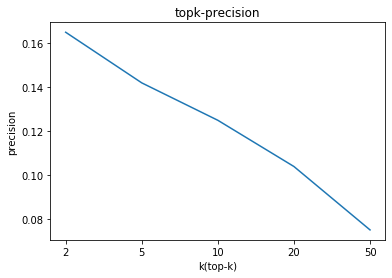

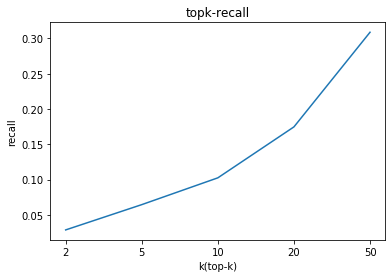

[{2: 0.165,
  5: 0.142,
  10: 0.12500000000000003,
  20: 0.10400000000000001,
  50: 0.07519999999999999},
 {2: 0.02862065039363801,
  5: 0.06444322934021077,
  10: 0.10241340502648551,
  20: 0.17461038557044753,
  50: 0.3086857652393256}]

In [ ]:
from matplotlib import pyplot as plt
DATASET='movie'
network = tf.keras.models.load_model('./log/movie/model/model_40.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
user_num = 100
k_list = [2, 5, 10, 20, 50]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall=topk_eval(network,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[2,5,10,20,50])
plt.plot(x,y)
plt.show()
data


In [ ]:
data

[{2: 0.155, 5: 0.132, 10: 0.12, 20: 0.1045, 50: 0.08199999999999999},
 {2: 0.033652121994126066,
  5: 0.06283168673311162,
  10: 0.09739141823475352,
  20: 0.2010322742247343,
  50: 0.347547200771365},
 {2: 0.055298385769039476,
  5: 0.08513792379298031,
  10: 0.1075200694035683,
  20: 0.1375165534298507,
  50: 0.13269261404602198}]

# last.fm数据集

In [ ]:
DEFAULT={
        'movie': {'epochs': 60, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 30, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-4, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='music'
history=train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 100 steps, validate for 34 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - AUC: 0.5000 - binary_accuracy: 0.5153 - val_loss: 0.6932 - val_AUC: 0.5000 - val_binary_accuracy: 0.5246
Train for 61 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


61/61 [==============================] - 1s 20ms/step - loss: -0.5080
Train for 100 steps, validate for 34 steps
Epoch 2/2
100/100 [==============================] - 0s 5ms/step - loss: 0.6932 - AUC: 0.5009 - binary_accuracy: 0.5026 - val_loss: 0.6931 - val_AUC: 0.5033 - val_binary_accuracy: 0.5063
Train for 100 steps, validate for 34 steps
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.6926 - AUC: 0.5387 - binary_accuracy: 0.5707 - val_loss: 0.6919 - val_AUC: 0.5975 - val_binary_accuracy: 0.6366
Train for 61 steps
Epoch 3/3
61/61 [==============================] - 0s 4ms/step - loss: -0.5202
Train for 100 steps, validate for 34 steps
Epoch 4/4
100/100 [==============================] - 0s 4ms/step - loss: 0.6890 - AUC: 0.7078 - binary_accuracy: 0.6475 - val_loss: 0.6856 - val_AUC: 0.7339 - val_binary_accuracy: 0.6931
Train for 100 steps, validate for 34 steps
Epoch 5/5
100/100 [==============================] - 1s 5ms/step - loss: 0.6759 - AUC: 0.7957 - bin

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network = tf.keras.models.load_model('./log/music/model/model_11.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


8469/8469 [==============================] - 1s 102us/sample - loss: 0.4856 - AUC: 0.8446 - binary_accuracy: 0.7716


[0.48559353984729614, 0.84459686, 0.77163774]

In [ ]:
network.evaluate([eval_data[:,0],eval_data[:,1],eval_data[:,1]],eval_data[:,2])

8469/8469 [==============================] - 0s 49us/sample - loss: 0.4729 - AUC: 0.8533 - binary_accuracy: 0.7786


[0.472894996689686, 0.85331774, 0.7786043]

/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded


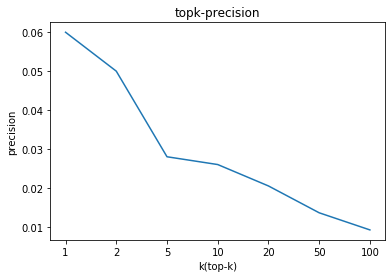

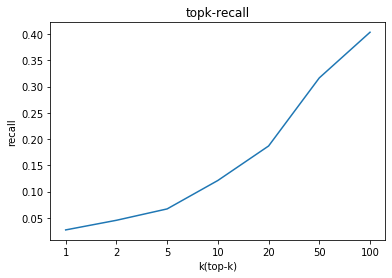

[{1: 0.06,
  2: 0.05,
  5: 0.028000000000000004,
  10: 0.026000000000000002,
  20: 0.020499999999999997,
  50: 0.013600000000000001,
  100: 0.009200000000000002},
 {1: 0.027000000000000003,
  2: 0.04533333333333333,
  5: 0.067,
  10: 0.12116666666666666,
  20: 0.18683333333333332,
  50: 0.3165833333333333,
  100: 0.4035},
 {1: 0.03724137931034483,
  2: 0.04755244755244755,
  5: 0.03949473684210527,
  10: 0.042813137032842584,
  20: 0.03694614147909967,
  50: 0.026079652718186866,
  100: 0.01798982311606494}]

In [ ]:
from matplotlib import pyplot as plt
DATASET='music'
network = tf.keras.models.load_model('./log/music/model/model_11.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
user_num = 100
k_list = [1, 2, 5, 10, 20, 50, 100]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall, f1=topk_eval(network,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall,f1]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[1,2,5,10,20,50,100])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[1,2,5,10,20,50,100])
plt.plot(x,y)
plt.show()
data

# book数据集

In [ ]:
DEFAULT={
        'movie': {'epochs': 30, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 4096, 'lr_rs': 0.02, 'lr_kg': 0.01,
                  'kge_interval': 3},
        'book': {'epochs': 10, 'dim': 8, 'L': 1, 'H': 1, 'batch_size': 32, 'lr_rs': 2e-4, 'lr_kg': 2e-5,
                 'kge_interval': 2},
        'music': {'epochs': 10, 'dim': 4, 'L': 2, 'H': 1, 'batch_size': 256, 'lr_rs': 1e-3, 'lr_kg': 2e-4,
                  'kge_interval': 2}
    }
DATASET='book'
history=train(DATASET,DEFAULT)

reading rating file ....
splitting dataset ...
reading KG file
data loaded
Train for 2621 steps, validate for 874 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2621/2621 [==============================] - 13s 5ms/step - loss: 0.6460 - AUC: 0.6604 - binary_accuracy: 0.5969 - val_loss: 0.5816 - val_AUC: 0.7365 - val_binary_accuracy: 0.6973
Train for 619 steps


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


619/619 [==============================] - 3s 4ms/step - loss: -0.5075
Train for 2621 steps, validate for 874 steps
Epoch 2/2
2621/2621 [==============================] - 12s 5ms/step - loss: 0.5363 - AUC: 0.7992 - binary_accuracy: 0.7333 - val_loss: 0.5818 - val_AUC: 0.7454 - val_binary_accuracy: 0.7000
Train for 2621 steps, validate for 874 steps
Epoch 3/3
2621/2621 [==============================] - 12s 5ms/step - loss: 0.4965 - AUC: 0.8373 - binary_accuracy: 0.7550 - val_loss: 0.5990 - val_AUC: 0.7454 - val_binary_accuracy: 0.6986
Train for 619 steps
Epoch 3/3
619/619 [==============================] - 2s 3ms/step - loss: -0.5232
Train for 2621 steps, validate for 874 steps
Epoch 4/4
2621/2621 [==============================] - 12s 4ms/step - loss: 0.4720 - AUC: 0.8534 - binary_accuracy: 0.7607 - val_loss: 0.6244 - val_AUC: 0.7432 - val_binary_accuracy: 0.6939
Train for 2621 steps, validate for 874 steps
Epoch 5/5
2621/2621 [==============================] - 12s 5ms/step - loss: 0.

In [ ]:
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
network = tf.keras.models.load_model('./log/book/model/model_3.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
network.evaluate([test_data[:,0],test_data[:,1],test_data[:,1]],test_data[:,2])

reading rating file ....
splitting dataset ...
reading KG file
data loaded


/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


27949/27949 [==============================] - 2s 62us/sample - loss: 0.5083 - AUC: 0.8282 - binary_accuracy: 0.7455


[0.5083015842034081, 0.8282367, 0.74550074]

In [ ]:
network.evaluate([eval_data[:,0],eval_data[:,1],eval_data[:,1]],eval_data[:,2])

27949/27949 [==============================] - 2s 56us/sample - loss: 0.5106 - AUC: 0.8258 - binary_accuracy: 0.7440


[0.5106167498908148, 0.8258266, 0.74403375]

/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yinpu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


reading rating file ....
splitting dataset ...
reading KG file
data loaded


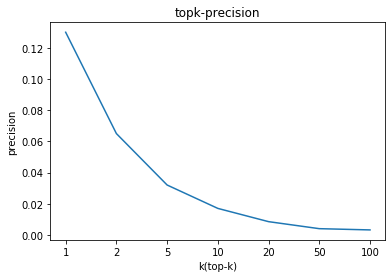

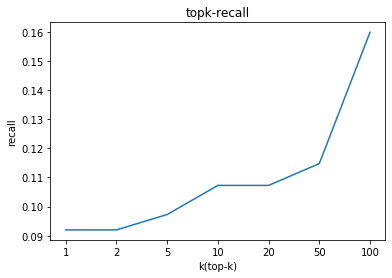

[{1: 0.13,
  2: 0.065,
  5: 0.032,
  10: 0.017,
  20: 0.0085,
  50: 0.004,
  100: 0.0032000000000000006},
 {1: 0.092,
  2: 0.092,
  5: 0.09727777777777778,
  10: 0.10727777777777778,
  20: 0.10727777777777778,
  50: 0.11477777777777778,
  100: 0.15985714285714286},
 {1: 0.10774774774774774,
  2: 0.07617834394904459,
  5: 0.048158143532445206,
  10: 0.029349128296826107,
  20: 0.015751919385796547,
  50: 0.007730589335827876,
  100: 0.006274399859821273}]

In [ ]:
from matplotlib import pyplot as plt
DATASET='book'
network = tf.keras.models.load_model('./log/book/model/model_3.h5',custom_objects={'CrossLayer':CrossLayer,'CompressLayer':CompressLayer})
n_user, n_item, n_entity, n_relation, train_data, eval_data, test_data, kg =load_data(DATASET)
user_num = 100
k_list = [1, 2, 5, 10, 20, 50, 100]
train_record = get_user_recoed(train_data, True)
test_record = get_user_recoed(test_data, False)
user_list = list(set(train_record.keys()) & set(test_record.keys()))
if len(user_list) > user_num:
    user_list = np.random.choice(user_list, size=user_num, replace=False)
item_set = set(list(range(n_item)))
precision, recall, f1=topk_eval(network,user_list,train_record,test_record,item_set,k_list)
data=[precision,recall,f1]
x=range(len(k_list))
y=[precision[k] for k in k_list]
plt.title('topk-precision')
plt.xlabel('k(top-k)')
plt.ylabel('precision')
plt.xticks(x,[1,2,5,10,20,50,100])
plt.plot(x,y)
plt.show()
x=range(len(k_list))
y=[recall[k] for k in k_list]
plt.title('topk-recall')
plt.xlabel('k(top-k)')
plt.ylabel('recall')
plt.xticks(x,[1,2,5,10,20,50,100])
plt.plot(x,y)
plt.show()
data

# 随机测试

In [ ]:
rs_model, kg_model = DFM_MKR_model(n_user, n_item, n_entity, n_relation, dim=DEFAULT[DATASET]['dim'], H=DEFAULT[DATASET]['H'],L=DEFAULT[DATASET]['L'])

In [ ]:
rs_model.compile(optimizer=tf.optimizers.Adam( DEFAULT[DATASET]['lr_rs']), loss=tf.keras.losses.binary_crossentropy,
                     metrics=['AUC', tf.keras.metrics.binary_accuracy])
rs_model.evaluate([eval_data[:,0],eval_data[:,1],eval_data[:,1]],eval_data[:,2])

# 时间

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
